## Traffic Sign Recognition
### by Wenzhe Ding


In this project, we will design and implement convolutional neural networks, specifically LeNet, to recognize traffic signs. We will train and test the model using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). After the model is finalized, we will then try out the model on images of German traffic signs that I find on the web. The steps of this project are the following:

* Load the data set
* Explore, summarize and visualize the data set
* Design, train and test a model architecture
* Use the model to make predictions on new images
* Analyze the softmax probabilities of the new images
* Summarize the results

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). 

## Table of contents
- [Data Exploration](#DataExploration)
- [Data Preprocessing](#DataPreprocessing)
   - [Normalization](#Normalization)
   - [RGB to Grayscale](#Grayscale)
   - [Up-sampling](#Up-sampling)
- [Model Architecture](#ModelArchitecture)
   - [Model Training](#ModelTraining)
- [Test Model on New Images](#test)
   - [Analyze Softmax Probabilities](#Probabilities)
   - [Visualize Feature Maps](#Feature)

In [1]:
import os
import glob
import pickle
import numpy as np
import collections
import math
import pandas as pd
from sklearn.utils import shuffle
import imageio

import tensorflow as tf
from tensorflow.contrib.layers import flatten

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

----
<a id='DataExploration'></a>
## Data Exploration
[[ go back to the top ]](#Table-of-contents)

Our training, validating and testing data can be downloaded [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip). This is a pickled dataset in with resized images of 32x32. I used pandas library to calculate summary statistics of the traffic signs data set. The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. Note that thest coordinates assume the original image, the pickled data contains resized versions (32 x 32) of original images.

In [2]:
# Load pickled data
training_file ="traffic-signs-data/train.p"
validation_file="traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Let's visualize the our training data set. 

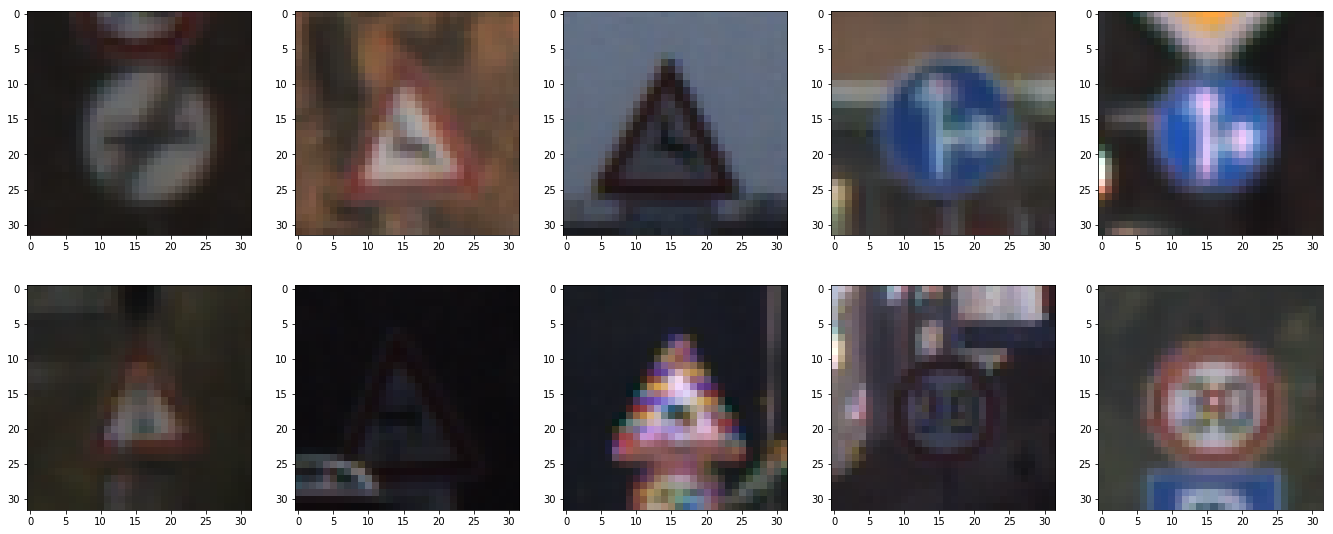

In [4]:
indexes = [i for i in range(0,3000,300)]
f, [[a1, a2, a3, a4, a5], [a6, a7, a8, a9, a10]] = plt.subplots(2, 5, figsize=(18, 8))
axes = [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10]
f.tight_layout()
for ax, index in zip(axes, indexes):
    ax.imshow(X_train[index].squeeze())
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

----
<a id='DataPreprocessing'></a>
## Data Pre-processing
[[ go back to the top ]](#Table-of-contents)

As a first step, I normalized the image data because it changes the range of pixel intensity values from 0 to 255 to -1 to 1. Next, I decided to convert the images to grayscale because my model may learn better from compressed images.

<a id='normalization'></a>
### Normalization
[[ go back to the top ]](#Table-of-contents)

We normalized the image data so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

In [5]:
print("summary before normalization \n")
for image in X_train[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(
          image.shape, image.min(), image.max()))

summary before normalization 

shape: (32, 32, 3), min: 19, max: 113
shape: (32, 32, 3), min: 19, max: 109
shape: (32, 32, 3), min: 19, max: 108
shape: (32, 32, 3), min: 18, max: 108
shape: (32, 32, 3), min: 16, max: 110


In [6]:
def normalize(x):
    return np.divide((x - 128.0), float(128.0))

X_train1 = normalize(X_train)
# X_valid = normalize(X_valid)
# X_test = normalize(X_test)
print("summary after normalization \n")
for image in X_train1[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(
          image.shape, image.min(), image.max()))

summary after normalization 

shape: (32, 32, 3), min: -0.8515625, max: -0.1171875
shape: (32, 32, 3), min: -0.8515625, max: -0.1484375
shape: (32, 32, 3), min: -0.8515625, max: -0.15625
shape: (32, 32, 3), min: -0.859375, max: -0.15625
shape: (32, 32, 3), min: -0.875, max: -0.140625


<a id='Grayscale'></a>
### RGB to Grayscale
[[ go back to the top ]](#Table-of-contents)

In [7]:
def rgb2gray_all(data):
    def rgb2gray(img):
        dot = np.dot(img[...,:3], [0.299, 0.587, 0.114])
        return dot[:, :, np.newaxis]
    res = []
    for i in data:
        res.append(rgb2gray(i))
    return res

X_train = rgb2gray_all(X_train)
X_valid = rgb2gray_all(X_valid)
X_test = rgb2gray_all(X_test)

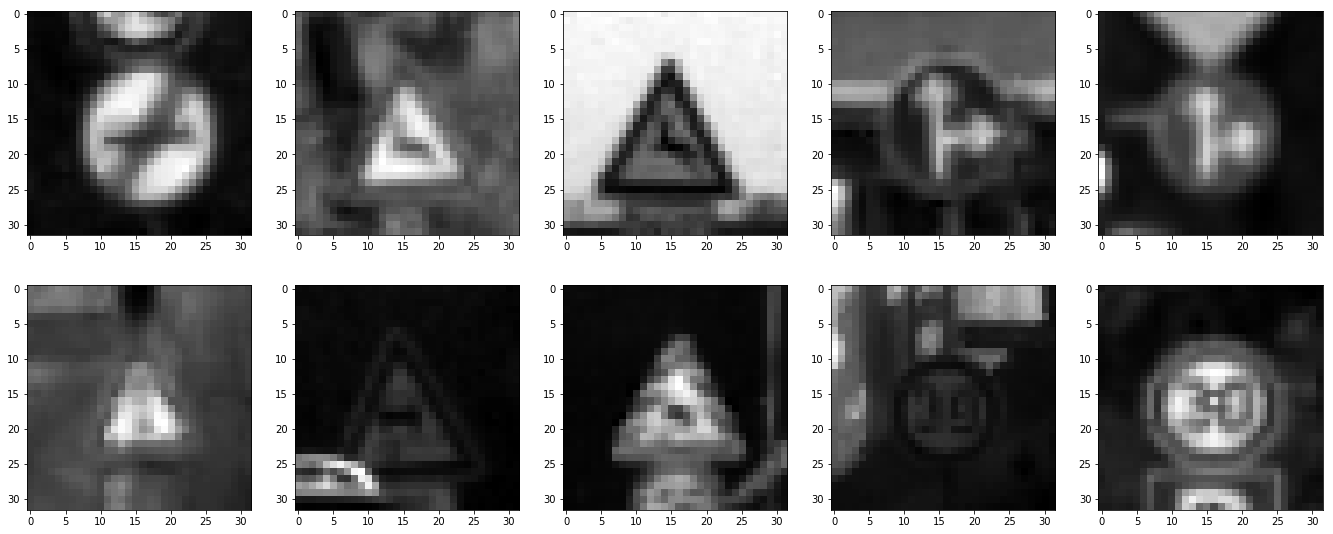

In [8]:
# indexes = [i for i in range(0,3000,300)]
f, [[a1, a2, a3, a4, a5], [a6, a7, a8, a9, a10]] = plt.subplots(2, 5, figsize=(18, 8))
axes = [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10]
f.tight_layout()
for ax, index in zip(axes, indexes):
    ax.imshow(X_train[index].squeeze(), cmap = plt.get_cmap('gray'))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

<a id='Upsampling'></a>
### Up-sampling
[[ go back to the top ]](#Table-of-contents)

To created a balanced training data, I used the following techniques because a balanced data set often improve model accuracy. For each labels with samples less than 3000, I random sampled data from training data and append them to existing training data. The final number of data points in training data is 17200.

In [9]:
counter_trn = collections.Counter(y_train)
print("Number of samples per label in training data \n")
print(counter_trn)

Number of samples per label in training data 

Counter({2: 2010, 1: 1980, 13: 1920, 12: 1890, 38: 1860, 10: 1800, 4: 1770, 5: 1650, 25: 1350, 9: 1320, 7: 1290, 3: 1260, 8: 1260, 11: 1170, 35: 1080, 18: 1080, 17: 990, 31: 690, 14: 690, 33: 599, 26: 540, 15: 540, 28: 480, 23: 450, 30: 390, 16: 360, 34: 360, 6: 360, 36: 330, 22: 330, 40: 300, 20: 300, 39: 270, 21: 270, 29: 240, 24: 240, 41: 210, 42: 210, 32: 210, 27: 210, 37: 180, 19: 180, 0: 180})


In [10]:
counter_vld = collections.Counter(y_valid)
print("Number of samples per label in validation data \n")
print(counter_vld)

Number of samples per label in validation data 

Counter({1: 240, 13: 240, 2: 240, 4: 210, 5: 210, 38: 210, 10: 210, 12: 210, 3: 150, 11: 150, 9: 150, 8: 150, 7: 150, 25: 150, 35: 120, 18: 120, 17: 120, 31: 90, 33: 90, 14: 90, 15: 90, 36: 60, 26: 60, 23: 60, 40: 60, 22: 60, 16: 60, 34: 60, 6: 60, 30: 60, 21: 60, 20: 60, 28: 60, 41: 30, 37: 30, 19: 30, 42: 30, 0: 30, 32: 30, 27: 30, 29: 30, 24: 30, 39: 30})


Here is an exploratory visualization of the data set. It is a line plot showing how the number of samples per label in train and validation data set respectively. The proportion of labels in the train and validation data have similar patterns. But the number of samples per label does not seem to be balanced in train and validation set. For example, the ratio between most frequently labels and least frequently labels is 8 in validation set and the ratio is around 11 in train data. To create a more balanced training data, for each labels with samples less than 2010/8, we random sample data from training data and append them to exsiting training data.

Text(0,0.5,'Percentage of Samples')

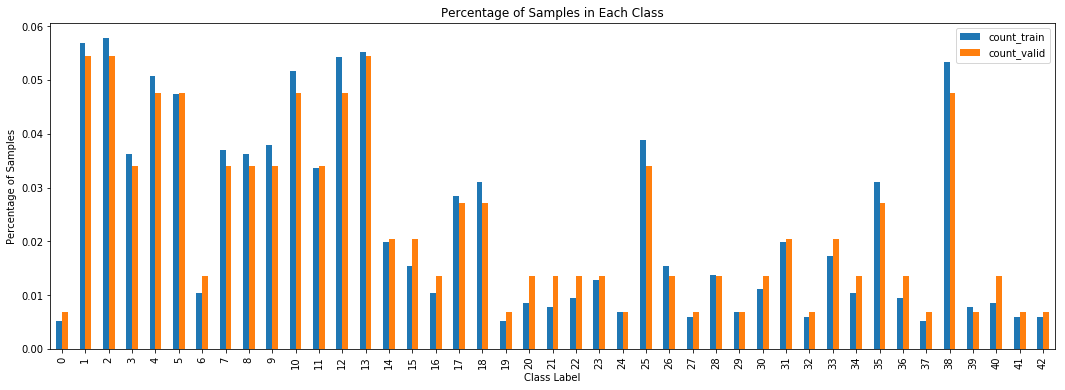

In [11]:
counter_trn_df = pd.DataFrame(counter_trn, index=["count_train"]).T
counter_vld_df = pd.DataFrame(counter_vld, index=["count_valid"]).T
counter_trn_df["count_valid"] = counter_vld_df["count_valid"]
counter_trn_df["count_train"] = counter_trn_df["count_train"] / sum(counter_trn_df["count_train"])
counter_trn_df["count_valid"] = counter_trn_df["count_valid"] / sum(counter_trn_df["count_valid"])
pplt = counter_trn_df.sort_index().plot(kind='bar', figsize=(18, 6))
pplt.set_title("Percentage of Samples in Each Class")
pplt.set_xlabel("Class Label")
pplt.set_ylabel("Percentage of Samples")

In [15]:
n = 4000
for num in counter_trn:
    if counter_trn[num] < n:
        # number of data to be added
        add_freq = n - counter_trn[num]
        # select corresponding y indexes
        y_idx = np.where(y_train == num)[0].tolist()
        # random sample data from existing data
        y_idx_select = [random.choice(y_idx) for _ in range(add_freq)]  
        y_train = np.append(y_train , [num] * add_freq)
        added_x = [X_train[i] for i in y_idx_select]
        X_train = np.append(X_train, added_x, axis=0)

# a more balaced count is shown as below
print("Number of samples after sampling", len(X_train))
counter_trn = collections.Counter(y_train)
print(counter_trn)

Number of samples after sampling 172000
Counter({41: 4000, 31: 4000, 36: 4000, 26: 4000, 23: 4000, 1: 4000, 40: 4000, 22: 4000, 37: 4000, 16: 4000, 3: 4000, 19: 4000, 4: 4000, 11: 4000, 42: 4000, 0: 4000, 32: 4000, 27: 4000, 29: 4000, 24: 4000, 9: 4000, 5: 4000, 38: 4000, 8: 4000, 10: 4000, 35: 4000, 34: 4000, 18: 4000, 6: 4000, 13: 4000, 7: 4000, 30: 4000, 39: 4000, 21: 4000, 20: 4000, 33: 4000, 28: 4000, 12: 4000, 14: 4000, 15: 4000, 17: 4000, 2: 4000, 25: 4000})


Now we have a more balanced data set and we are ready to start designing our model!

----
<a id='ModelArchitecture'></a>
## Model Architecture
[[ go back to the top ]](#Table-of-contents)


We utilize a LeNet-5 Architecture, which is shown below. 
![image](https://github.com/wzding/Self_Driving_Car_Nanodegree/raw/master/LeNet/lenet.png)
Source: Yan LeCun

In order to adapt our data to this model architecture, we changed a few parameters and the final structure consists of the following layers:

| Layer         		|     Description	        					|
|:---------------------:|:---------------------------------------------:|
| Input         		| 32x32x1 RGB image   							|
| Convolution 3x3     	| 1x1 stride, same padding, outputs 28x28x6 	|
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 14x14x6 				|
| Convolution 3x3	    |  1x1 stride,  outputs 10x10x6			|
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 5x5x6 				|
| Flatten				| inputs 5x5x16,  outputs 400      									|
| Fully connected		|inputs 400,  outputs 120      									|
| RELU					|												|
| Fully connected		|inputs 120,  outputs 84      									|
| RELU					|												|
| Fully connected		|inputs 84,  outputs 43      									|



In [16]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1, name='convolution0')

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='convolution1')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2, name='convolution2')

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='convolution3')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

<a id='ModelTraining'></a>
### Model Training
[[ go back to the top ]](#Table-of-contents)

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

During training, I observed that the accuracy of training set is always larger than that of validation set. This might be an overfitting problem. After discovering this problem, I tried to add dropout layers to one or two fully connected layers, but it turned out the accuracy of validation went down as well. Since added dropout layers did not help solve overfitting, I added more data to the training set and uses the new data for training, which turned out to be a good method to increase accuracy of validation set. 

I tuned the number of epochs from 20 to 40, and the final choice is 30 because the accuracy of validation set does not change much after 30 epochs. Finally, I used an 128 batch size, 30 epoches, and learning rate 0.001. My optimizer is AdamOptimizer because it makes learning less sensitive to hyperparameters. 


In [17]:
EPOCHS = 30
BATCH_SIZE = 128
rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [18]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [19]:
### model training
epoc = []
training_res = []
validation_res = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        print("EPOCH {} ...".format(i+1))
        epoc.append(i+1)
        training_accuracy = evaluate(X_train, y_train)
        training_res.append(training_accuracy)
#         print("Training Accuracy = {:.3f}".format(training_accuracy))
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_res.append(validation_accuracy)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

Training...

EPOCH 1 ...
Validation Accuracy = 0.867

EPOCH 2 ...
Validation Accuracy = 0.899

EPOCH 3 ...
Validation Accuracy = 0.896

EPOCH 4 ...
Validation Accuracy = 0.895

EPOCH 5 ...
Validation Accuracy = 0.896

EPOCH 6 ...
Validation Accuracy = 0.910

EPOCH 7 ...
Validation Accuracy = 0.908

EPOCH 8 ...
Validation Accuracy = 0.918

EPOCH 9 ...
Validation Accuracy = 0.933

EPOCH 10 ...
Validation Accuracy = 0.930

EPOCH 11 ...
Validation Accuracy = 0.934

EPOCH 12 ...
Validation Accuracy = 0.927

EPOCH 13 ...
Validation Accuracy = 0.900

EPOCH 14 ...
Validation Accuracy = 0.924

EPOCH 15 ...
Validation Accuracy = 0.913

EPOCH 16 ...
Validation Accuracy = 0.915

EPOCH 17 ...
Validation Accuracy = 0.927

EPOCH 18 ...
Validation Accuracy = 0.922

EPOCH 19 ...
Validation Accuracy = 0.923

EPOCH 20 ...
Validation Accuracy = 0.926

EPOCH 21 ...
Validation Accuracy = 0.927

EPOCH 22 ...
Validation Accuracy = 0.929

EPOCH 23 ...
Validation Accuracy = 0.929

EPOCH 24 ...
Validation Accura

The following graph shows changes in accuracy of train and validation set as the number of epoch increases.

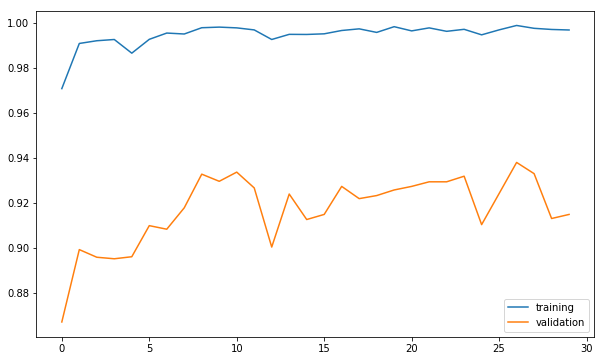

In [20]:
res = {'epoch': epoc, 'training': training_res, 'validation': validation_res}
res = pd.DataFrame.from_dict(res)
res[['training', 'validation']].plot(figsize=(10, 6))

In [21]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.914


My final model results are:
* validation set accuracy of 0.915
* test set accuracy of 0.914

---
<a id='test'></a>
## Test Model on New Images
[[ go back to the top ]](#Table-of-contents)

I download five pictures of German traffic signs from the web and use the above model to predict the traffic sign type. The last image might be difficult to classify because it is hard to differentiate the image from its background color.

image shape:  (27, 27, 3)
image shape:  (28, 29, 3)
image shape:  (31, 31, 3)
image shape:  (27, 26, 3)
image shape:  (30, 27, 3)


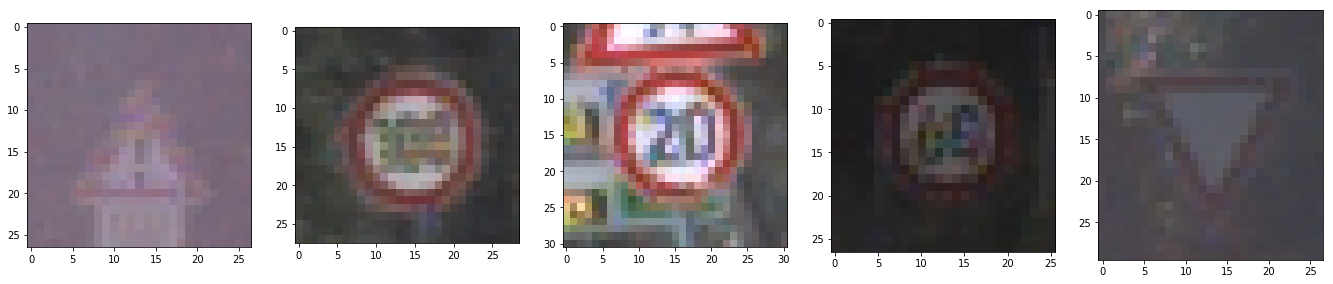

In [22]:
### Load the images and plot them here.
y_test_new = []
file_list = []
for file in os.listdir('download/'):
    if file.endswith(".ppm"):
        y_test_new.append(os.path.splitext(file)[0][:2])
        file_list.append('download/' + file)
        image = mpimg.imread('download/' + file)
        print("image shape: ", image.shape)

f, [a1, a2, a3, a4, a5] = plt.subplots(1, 5, figsize=(18, 4))
axes = [a1, a2, a3, a4, a5]
f.tight_layout()
for ax, file in zip(axes, file_list):
    image = mpimg.imread(file)
    ax.imshow(image)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Note that the dimension of each image is not (32, 32, 3), so we need to pad the data with rows of zeros.

In [20]:
for file in os.listdir('download/'):
    if file.endswith(".ppm"):
        image = mpimg.imread('download/' + file)
        if file.startswith("00"):
            image = np.pad(image, ((1,0),(1,0),(0,0)), 'constant')
        if file.startswith("13"):
            image = np.pad(image, ((1,1),(3,2),(0,0)), 'constant')
        if file.startswith("18"):
            image = np.pad(image, ((3,2),(3,2),(0,0)), 'constant')
        if file.startswith("03"):
            image = np.pad(image, ((3,2),(3,3),(0,0)), 'constant')
        if file.startswith("07"):
            image = np.pad(image, ((2,2),(2,1),(0,0)), 'constant')
        imageio.imwrite('download/padded/' + os.path.splitext(file)[0] + "_padded.ppm", image)

In [23]:
filelist = glob.glob('download/padded/*_padded.ppm')
X_test_new = np.array([mpimg.imread(fname) for fname in filelist])
y_test_new = np.array(y_test_new)
# convert new test data into grayscale
X_test_new = np.array(rgb2gray_all(X_test_new))
print("Shape of new test data ", X_test_new.shape)
print("New test data labels ", y_test_new)

Shape of new test data  (5, 32, 32, 1)
New test data labels  ['18' '07' '00' '03' '13']


Next, we'd like to examine the predictions for each image using our model.

In [26]:
### Run the predictions here and use the model to output the prediction for each image.
def get_prediction(X_data):
    sess = tf.get_default_session()
    pred = sess.run(tf.argmax(logits, 1), feed_dict={x: X_data})
    return pred

In [27]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred = get_prediction(X_test_new)
    print("Predictions are ", pred)
    ### Calculate the accuracy for these 5 new images. 
    print("accuracy is: ", sum([int(pred[i]) == int(y_test_new[i]) for i in range(len(pred))]) / len(pred) * 100)

INFO:tensorflow:Restoring parameters from ./lenet
Predictions are  [ 0  3  7 13 38]
accuracy is:  80.0


Here are the results of the prediction:

| Image			        |     Prediction	        					|
|:---------------------:|:---------------------------------------------:|
| Speed limit (20km/h)     		| Speed limit (120km/h)   									|
| Speed limit (60km/h)      	| Speed limit (60km/h) 			 				|
| Speed limit (100km/h)			| Speed limit (100km/h)     							|
| Yield					| Yield											|
| General caution     			|Keep right							|

The model was able to correctly guess 4 of the 5 traffic signs, which gives an accuracy of 80%. This is much less than the accuracy on the test set of 0.902.

<a id='Probabilities'></a>
### Analyze Softmax Probabilities
[[ go back to the top ]](#Table-of-contents)

For each of the new images, we want to check the model's softmax probabilities, which shows the **certainty** of the model's predictions. We'll limit the output to the top 5 probabilities for each image.  `tf.nn.top_k`  can be used to find the top k predictions for each image. It returns the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

In [28]:
# obtain the probability of each prediction using softmax
def get_pred_prob(X_data):
    sess = tf.get_default_session()
    pred = sess.run(tf.nn.softmax(logits), feed_dict={x: X_data})
    return pred

In [29]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred = get_pred_prob(X_test_new)
    res = sess.run(tf.nn.top_k(tf.constant(pred), k=5))

INFO:tensorflow:Restoring parameters from ./lenet


In [31]:
print("Results are shown below")
res

Results are shown below


TopKV2(values=array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 2.38563782e-08, 5.24995984e-11, 5.13450556e-13,
        1.34935208e-13],
       [1.00000000e+00, 7.39539861e-38, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 4.03526364e-25, 1.07296723e-28, 1.15202584e-29,
        6.03723828e-38],
       [9.98888433e-01, 6.44524931e-04, 2.92059820e-04, 1.35274531e-04,
        2.43438772e-05]], dtype=float32), indices=array([[ 0,  1,  2,  3,  4],
       [ 3, 12, 15, 35,  2],
       [ 7,  2,  0,  1,  3],
       [13, 38,  5,  1,  2],
       [38, 20, 32, 31,  5]], dtype=int32))

For the first four images, the model is very sure that they belong to certain class (both of them have probability of 1). And the results are correct.
For the last image, the model is relatively sure that this is a keep right sign, but it turned out that is is a sign of General caution. Part of the reason that the model is not able to recogonize its true label is that the image is kind of blendding into the image backgroud. 

<a id='Feature'></a>
### Visualize Feature Maps
[[ go back to the top ]](#Table-of-contents)

While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training our neural network we can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

In [30]:
### Visualize your network's feature maps here.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, figure_title="Layer_Visualization", activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(18,12))
    plt.suptitle(figure_title, fontsize=18)
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./lenet
Model restored.


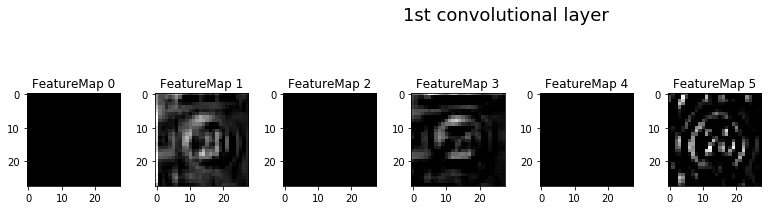

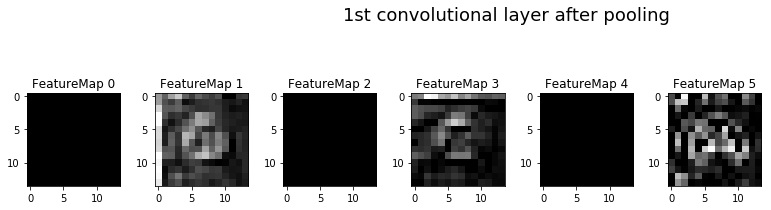

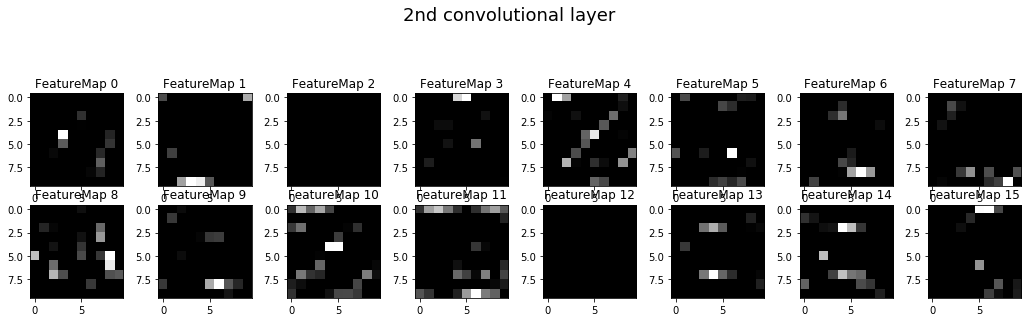

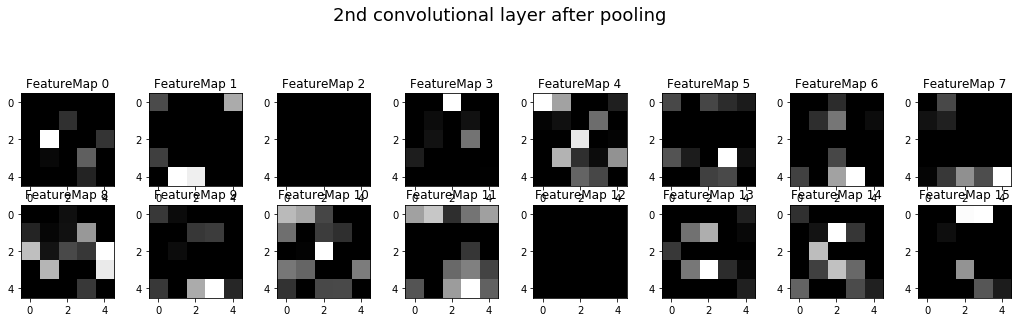

In [31]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Model restored.")
#     index = random.randint(0, len(X_train))
#     image = X_train[index].squeeze()
#     images_TF = tf.reshape(np.array(image), [1, 32, 32, 1])
    
    conv1 = sess.graph.get_tensor_by_name('convolution0:0')
    outputFeatureMap(X_test_new, conv1, figure_title="1st convolutional layer", 
                     activation_min=-1, activation_max=-1, plt_num=1)
    
    conv1 = sess.graph.get_tensor_by_name('convolution1:0')
    outputFeatureMap(X_test_new, conv1, figure_title="1st convolutional layer after pooling", 
                     activation_min=-1, activation_max=-1, plt_num=2)
    
    conv2 = sess.graph.get_tensor_by_name('convolution2:0')
    outputFeatureMap(X_test_new, conv2, figure_title="2nd convolutional layer", 
                     activation_min=-1, activation_max=-1, plt_num=3)
    
    conv2 = sess.graph.get_tensor_by_name('convolution3:0')
    outputFeatureMap(X_test_new, conv2, figure_title="2nd convolutional layer after pooling", 
                     activation_min=-1, activation_max=-1, plt_num=4)